# 데이터 다운로드

In [5]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    # 작업 공간에 datasets\housing 디렉토리 생성
    if not os.path.join(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    # housing.tgz 파일 내려받기
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

# 데이터 로드

In [9]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# 데이터 구조 훑기

In [11]:
# 데이터 구조
housing.info()

# total_bedrooms null값 존재

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [13]:
# 범주형 특성 카테고리 확인
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [14]:
# 숫자형 특성 통계량
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


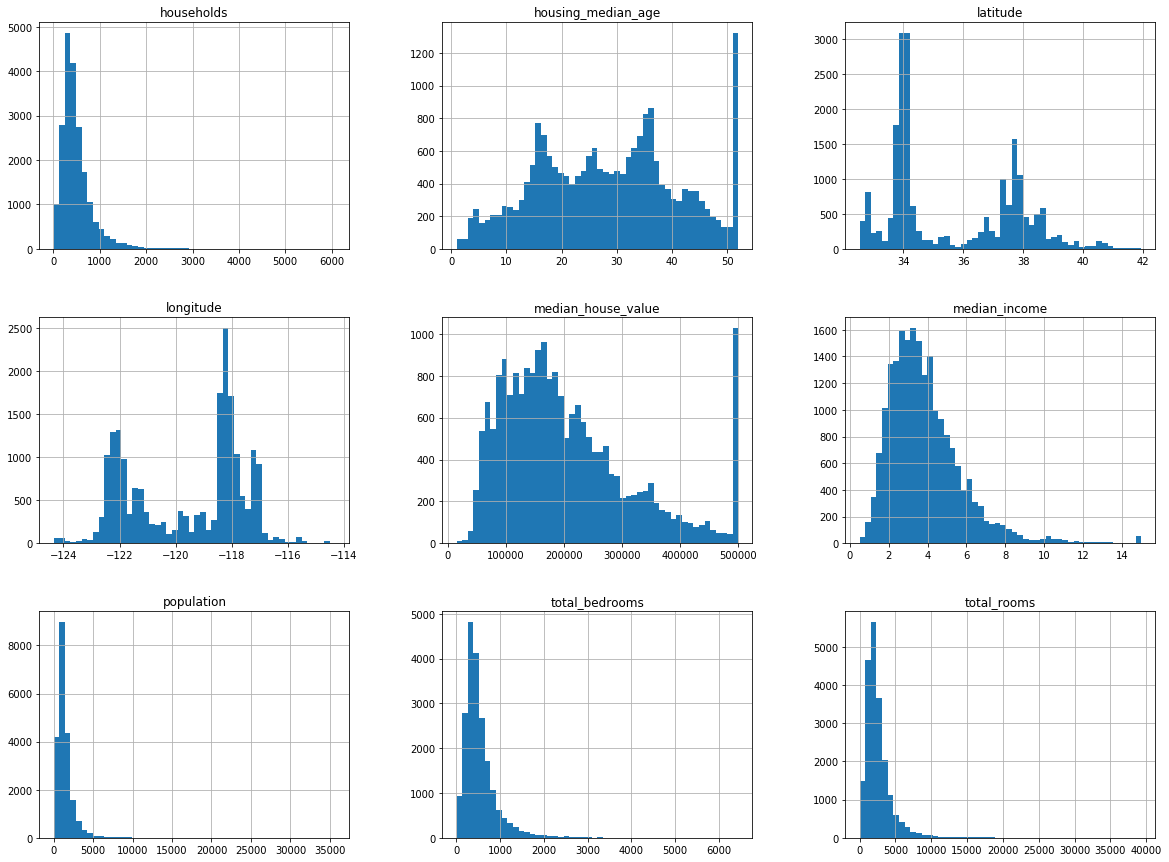

In [18]:
# 히스토그램
%matplotlib inline
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20, 15))
plt.show()

# median_income이 US달러가 아님
# housing_median_age, median_house_value 최대, 최소값 한정됨
# 특성 스케일들이 많이 다름
# 특성들이 꼬리가 두껍다.

# 테스트 세트 만들기
## 1. 무작위 샘플링(Random sampling)
* 데이터 스누핑(snooping) 편향이 생길 수 있음

### 1.1 함수 정의해서 테스트 세트 나누기

In [31]:
# 식별자에 의해 테스트 세트 나누는 함수 정의
import numpy as np
from zlib import crc32

# 파이썬 2, 3 모두 호환되는 
def test_set_check(identifier, test_ratio):
    # 파이썬 2와 호환성을 위해 crc32 결과에 비트 연산
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2 ** 32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    
    return data.loc[~in_test_set], data.loc[in_test_set]

In [39]:
# index로 테스트 세트 나누기
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
5,5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY
16,16,-122.27,37.85,52.0,1966.0,347.0,793.0,331.0,2.7750,152500.0,NEAR BAY
23,23,-122.27,37.84,52.0,1688.0,337.0,853.0,325.0,2.1806,99700.0,NEAR BAY


In [40]:
# 새로운 식별자 정의해서 나누기
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
59,59,-122.29,37.82,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY,-122252.18
60,60,-122.29,37.83,52.0,1121.0,211.0,554.0,187.0,3.3929,75700.0,NEAR BAY,-122252.17
61,61,-122.29,37.82,49.0,135.0,29.0,86.0,23.0,6.1183,75000.0,NEAR BAY,-122252.18
62,62,-122.29,37.81,50.0,760.0,190.0,377.0,122.0,0.9011,86100.0,NEAR BAY,-122252.19
67,67,-122.29,37.80,52.0,1027.0,244.0,492.0,147.0,2.6094,81300.0,NEAR BAY,-122252.20


### 1.2 scikit-learn 메서드를 이용한 테스트 세트 나누기

In [41]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


## 2. 계층적 샘플링(Stratified sampling)
* 분포 비율을 유지하여 샘플링 하는 방법

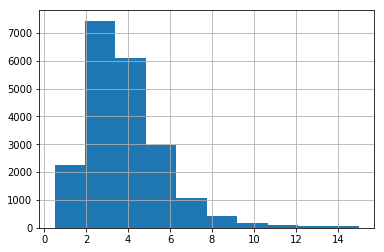

In [42]:
# median_income이 median_house_value를 예측하는데 매우 중요하다면
# 테스트 세트의 median_income이 전체 데이터셋에 있는 여러 소득 카테고리를 잘 
# 대표해야 한다.
# 따라서 median_income을 계층별로 나누어 범주형 특성으로 변경

housing["median_income"].hist()

# 계층을 나눌 때 계층별 충분한 샘플 수가 있어야 한다.
# 안 그러면 계층의 중요도 추정 시 편향 발생
# 즉 너무 많은 계층으로 나누면 안 된다.

## 1. median_income 특성 계층 나누기

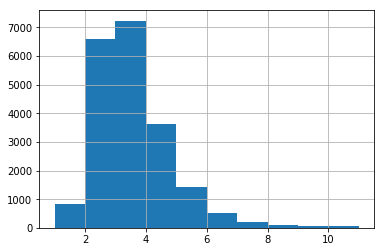

In [49]:
# 중간 소득 1.5로 나누기(소득 카테고리 수 제한 목적) 
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5) # 올림(이산데이터)
housing["income_cat"].hist()

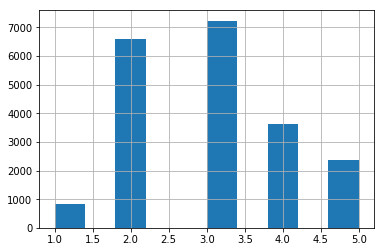

In [53]:
# where(cond, other)
# cond이 True이면 데이터 유지, False이면 other 반영
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
housing["income_cat"].hist()

In [54]:
housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

### StratifiedKFold와 StratifiedShuffleSplit
* StratifiedKFold는 계층 샘플링 시 테스트 세트의 인덱스가 겹치지 않게 한다.
* StratifiedShuffleSplit는 계층 샘플링 시 테스트 세트의 인덱스가 겹치게 한다.
* 예) n_splits=2, test_size=0.2일 때 나눌 전체 index가 0 ~ 5이면
    * StratifiedKFold
        * train index: [1, 2, 3, 4]
        * test index: [0]  
        ---------------------------------
        * train index: [0, 1, 3, 4]
        * test index: [2]
    * StratifiedShuffleSplit
        * train index: [0, 2, 3, 4]
        * test index: [1]  
        ---------------------------------
        * train index: [0, 2, 3, 4]
        * test index: [1]

In [64]:
from sklearn.model_selection import StratifiedShuffleSplit

# StratifiedKFold의 계층 샘플링 + ShuffleSplit의 랜덤 샘플링
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# 데이터 탐색 및 시각화

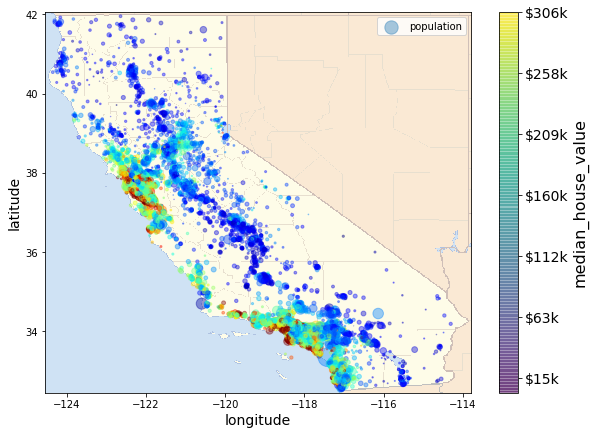

In [84]:
# 테스트 세트 때어놓고 훈련 세트만 탐색
housing = strat_train_set.copy()

import matplotlib.image as mpimg

california_img = mpimg.imread("images\end_to_end_project\california.png")
# s : 원의 반지름, c : 가격, cmap : 미리 정의된 컬러맵, 
# jet : 파랑(낮음) ~ 빨강(높음) 형식, 
# sharex=False : x축 값과 범례 표시 못하는 버그 수정용
ax = housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
            s=housing["population"]/100, label="population", figsize=(10, 7),
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=False,
            sharex=False)
# 추가 옵션
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel("latitude", fontsize=14)
plt.xlabel("longitude", fontsize=14)
# 가격 단위 변경
prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label("median_house_value", fontsize=16)
plt.legend()

# 경도 -122˚ : 베이 에어리어, 샌프란시스코 
# 경도 -121.5˚, 위도 38.5˚ : 새크라멘토
# 경도 -119.8˚, 위도 36.7˚ : 프레즈노
# 경도 -118˚ : 로스앤젤레스
# 경도 -117˚ : 샌디에이고
# 샌트럴 밸리 : 샌프란시스코 위 ~ 로스앤젤레스 위의 캘리포니아 중앙부에 길게 뻗은 지역

# 해안 근접성 특성이 유용하지 않다.
#  - 북부 캘리포니아 지역(대략 위도 35˚)의 해안가 주택 가격이 그리 높지 않기 때문에
#  - 베이 에어리어 지역(경도 -122˚)을 제외하고 해안가의 주택 가격이 높지 않다.

# 상관관계 조사

In [89]:
# 피어슨 상관계수 행렬
corr_matrix = housing.corr()
# 내림차순 정렬
corr_matrix["median_house_value"].sort_values(ascending=False)

# 중간 소득과 양의 상관관계
# 위도와 약한 음의 상관관계
#  - 북쪽으로 갈수록 주택 가격 감소 경향

median_house_value    1.000000
median_income         0.687160
income_cat            0.642274
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000228DE44E2E8>,
      dtype=object)

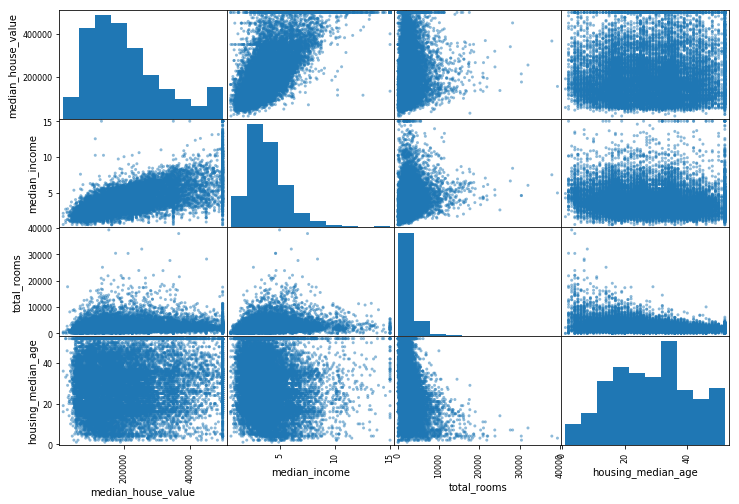

In [90]:
# 상관관계 산점도행렬 그리기
from pandas.plotting import scatter_matrix

# 상관관계 높은 특성 선택
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

[0, 16, 0, 550000]

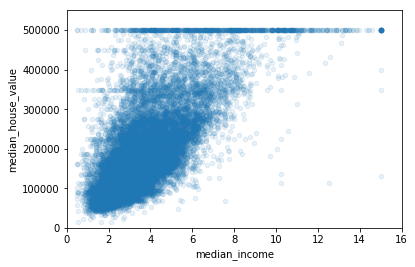

In [93]:
# 가장 상관관계 높은 median_income과의 상관관계 산점도 확대
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.axis([0, 16, 0, 550000])

# 수평선 형태 
#  - median_house_value의 제한값 $500,000
#  - $450,000 근처
#  - $350,000
#  - $280,000
#  - 그 아래 부분
# 알고리즘이 데이터에서 수평선 형태를 학습하지 않도록 해당 구역을 제거하는 것이 좋다.

# 특성 조합으로 실험

In [94]:
# 가구당 방 개수
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
# 방과 침대 비율
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
# 가구당 인원
housing["population_per_household"] = housing["population"] / housing["households"]

In [95]:
# 상관관계 행렬
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

# bedrooms_per_room가 total_rooms나 total_bedrooms보다 상관관계가 높다.
#  - 침대/방 비율이 낮은 집은 더 비싼 경향
# rooms_per_household보면 더 큰 집이 더 비쌈

median_house_value          1.000000
median_income               0.687160
income_cat                  0.642274
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

[0, 5, 0, 520000]

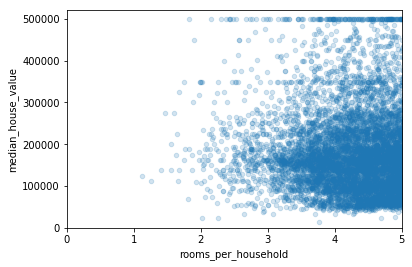

In [101]:
# 가구당 방 수와의 산점도 그리기
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value", 
             alpha=0.2)
plt.axis([0, 5, 0, 520000])

In [102]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,income_cat,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,3.006541,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,1.054602,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,2.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,3.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,4.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,5.000000,141.909091,1.000000,1243.333333


# 머신러닝 알고리즘을 위한 데이터 준비
이 과정은 자동화하는 것이 좋다!

In [103]:
# 계층 샘플링한 훈련 세트를 예측 변수와 레이블로 분리
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## 1. 데이터 정제(결측치 제어)
### 1.1 수동 제어

In [106]:
# null값 특성 확인하기
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN,2.0
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN,4.0
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN,4.0
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND,2.0
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN,3.0


In [107]:
# null값 샘플 제거
sample_incomplete_rows.dropna(subset=["total_bedrooms"])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat


In [108]:
# null값 특성 제거
sample_incomplete_rows.drop("total_bedrooms", axis=1)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity,income_cat
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN,2.0
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN,4.0
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN,4.0
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND,2.0
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN,3.0


In [109]:
# null값 median으로 채우기
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)
sample_incomplete_rows

# null값에 채우는 값은 저장해놔야 한다.
#  - 시스템 평가 시 테스트 세트의 null값에 채우기 위해
#    (테스트 세트의 중간값 등을 사용하면 안된다. 훈련 세트에서 학습한 것이 소용없어
#     진다.)
#  - 시스템 실제 운영 시 새로운 데이터에서 null값을 채우기 위해

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN,2.0
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN,4.0
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN,4.0
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND,2.0
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN,3.0


### 1.2 scikit-learn의 SimpleImuter를 이용한 결측치 제어
현재 null값을 가진 특성 외 추후에 생길 null값을 대비한 code

In [112]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
# 수치형 특성 데이터프레임
housing_num = housing.drop("ocean_proximity", axis=1)
# 추후 생길 null값을 대비해 모든 특성에 imputer 적용
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [125]:
# 각 특성별 중간값을 저장한 배열
imputer.statistics_
# housing_num.median().values # 수동 계산한 특성별 중간값 배열

# imputer.strategy # 전략 정보

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409,    3.    ])

In [121]:
# 학습한 특성별 중간값으로 훈련 세트 대체하기
X = imputer.transform(housing_num)

array([[-121.89  ,   37.29  ,   38.    , ...,  339.    ,    2.7042,
           2.    ],
       [-121.93  ,   37.05  ,   14.    , ...,  113.    ,    6.4214,
           5.    ],
       [-117.2   ,   32.77  ,   31.    , ...,  462.    ,    2.8621,
           2.    ],
       ...,
       [-116.4   ,   34.09  ,    9.    , ...,  765.    ,    3.2723,
           3.    ],
       [-118.01  ,   33.82  ,   31.    , ...,  356.    ,    4.0625,
           3.    ],
       [-122.45  ,   37.77  ,   52.    , ...,  639.    ,    3.575 ,
           3.    ]])

In [123]:
# Pandas 데이터프레임으로 되돌림
housing_tr = pd.DataFrame(X, columns=housing_num.columns, 
                         index=list(housing.index.values))

housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,2.0
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,4.0
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,4.0
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,2.0
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,3.0


# 텍스트, 범주형 특성 다루기

## 1. pandas 데이터프레임을 이용한 원-핫 인코딩

In [141]:
housing_tmp = housing.copy()

housing_cat_1hot_pd = pd.get_dummies(housing_tmp)
housing_cat_1hot_pd.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,2.0,1,0,0,0,0
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,5.0,1,0,0,0,0
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,2.0,0,0,0,0,1
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,2.0,0,1,0,0,0
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,3.0,1,0,0,0,0


## 2. scikit-learn OneHotEncoder를 이용한 범주화 된 정수형 데이터의 원-핫 인코딩
* OneHotEncoder는 입력으로 Numpy 배열을 받는 듯

In [155]:
housing_cat = housing["ocean_proximity"]
housing_cat.head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

In [156]:
# 카테고리 → 정수값 변환
housing_cat_encoded, housing_categories = housing_cat.factorize()
housing_cat_encoded[:10]

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0], dtype=int64)

In [159]:
housing_categories

Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')

* 이대로 사용하면 머신러닝 알고리즘이 가까이 있는 두 값이 떨어져 있는 두 값보다 더 비슷하다고 생각한다.
    * 범주화 된 정수값 근접 정도 때문에를 말하는 듯?
* 카테고리별 이진 특성을 만드는 원-핫 벡터를 사용해야 한다. 

In [134]:
from sklearn.preprocessing import OneHotEncoder

# 인코딩 방식은 원-핫 벡터
encoder = OneHotEncoder(categories='auto') # categories 매개변수는 경고 메세지 회피용
# fit_transform()에서 요구하는 2차원 배열 만들기
housing_cat_encoded_reshaped = housing_cat_encoded.reshape(-1, 1) # -1 : 차원 미지정
# Scipy의 csr_matrix 희소행렬 반환
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded_reshaped)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [137]:
# 밀집 배열로 변환
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

## 3. scikit-learn OneHotEncoder를 이용한 범주형 데이터의 원-핫 인코딩

In [162]:
housing_cat_reshaped = housing_cat.values.reshape(-1, 1)
housing_cat_1hot = encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [143]:
# 밀집 배열로 변환
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

### 3.1 밀집 배열 바로 얻기

In [144]:
cat_encoder = OneHotEncoder(categories='auto', sparse=False) # sparse 옵션 False
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

## 4. scikit-learn OrdinalEncoder를 이용한 원-핫 인코딩
* 입력 특성(X)을 위해 설계되었고, 파이프라인과 잘 작동되어 더 좋은 방법
* OrdinalEncoder는 Pandas 데이터프레임을 입력으로 받는 듯

In [164]:
housing_cat = housing[["ocean_proximity"]] # 2차원 배열
housing_cat.head()

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN


In [167]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [166]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

# 나만의 변환기
* fit_transform() 메소드를 사용하려면 TransformerMixin 상속
* get_params(), set_params() 메소드를 사용하려면 BaseEstimaotr 상속
    * 두 메서드는 생성자에 명시된 매개변수만 참조
    * args, *kargs 사용 불가

In [185]:
# 조합 특성을 추가하는 변환기
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # *args나 **kargs가 아님
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self # 더 할 일 없음
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [186]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,2,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,5,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,2,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,2,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,3,4.50581,3.04785


# 특성 스케일링

* 모든 변환기에서 스케일링은 훈련 데이터에 대한 fit()을 하고 그 데이터를 훈련 세트, 테스트 세트, 새로운 데이터 transform() 한다.

## 1. min-max 스케일링(정규화, Normalizer)
* scikit-learn의 MinMaxScaler 변환기
* 스케일 : 0 ~ 1(feature_range 매개변수로 조정 가능)
* 공식 : (관측값 - min) / (max - min)
* 이상치의 영향이 큼
    * max - min 범위가 커져 샘플값이 매우 작아짐
    * median_income에 100이 들어오면 0 ~ 15 범위가 0 ~ 0.15, 1로 작아짐


## 2. 또 다른 정규화?
* scikit-learn의 Normalizer 변환기
* 입력 데이터에서 각 행의 l2 노름이 1이 되도록 조정
* min-max 스케일링과는 전혀 다른 결과

## 3. 표준화(standardization)
* sckit-learn의 StandardScaler 변환기
* 스케일 : 평균 0, 분산 1 정규 분포
* 공식 : (관측값 - 평균) / 표준편차
* 상한, 하한이 없어 어떤 알고리즘에는 문제의 소지가 있음
* 이상치에 영향이 적음  

# 변환 파이프라인
## 1. scikit-learn의 Pipeline을 이용한 파이프라인
* Pipeline은 연속된 단계의 (이름, 추정치) 쌍의 목록을 입력으로 받는다.
    *  마지막 단계에는 변환기와 추정기 모두 사용 가능
    * 그 외는 모두 변환기여야 함
    * 즉 fit_transform() 또는 fit()과 transform() 메서드를 가지고 있어야 함
* 파이프라인의 fit() 호출 시
    * 모든 변환기의 fit_transform() 또는 fit()과 transform()을 순서대로 호출하면서, 한 단계의 출력을 다음 단계의 입력으로 전달
    * 마지막 단계에는 fit()만 호출
* 파이프라인 객체는 마지막 추정기 또는 변환기와 동일한 메서드를 제공

In [207]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# 파이프라인 객체
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])
# 마지막 변환기인 StandardScaler() 변환기의 fit_transform() 메서드 사용 가능
housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

## 2. scikit-learn의 ColumnTransformer를 이용한 파이프라인

In [209]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num_pipeline", num_pipeline, num_attribs),
    ("cat_encoder", OneHotEncoder(categories='auto'), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [213]:
housing_prepared.shape

(16512, 17)

# 훈련 세트에서 훈련, 평가
## 1. 선형 회귀 모델 훈련 평가

In [214]:
# 선형 회귀 모델 훈련
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [225]:
# 훈련 세트에 대한 회귀 모델의 RMSE
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
# 오차
lin_rmse

# 예측 오차가 큼 → 과소적합
# 좋은 예측을 만드는 정보가 충분치 못하거나, 모델이 강력하지 못함

68376.64295459937

### 과소적합 해결법
* 더 강력한 모델 선택
* 더 좋은 특성 주입
* 규제 감소시키기

In [226]:
# MAE
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49508.082059709115

## 2. 결정트리 모델 훈련, 평가
* 선형 회귀 보다 강력하고, 복잡한 비선형 관계를 찾을 수 있다.

In [242]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
# 모델 훈련
tree_reg.fit(housing_prepared, housing_labels)
# 훈련 세트로 예측
housing_predictions = tree_reg.predict(housing_prepared)
# 모델 평가
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
# 오차
tree_rmse

# 오차가 없다 → 과대적합

0.0

## 3. 랜덤 포레스트 모델 훈련, 평가

In [243]:
from sklearn.ensemble import RandomForestRegressor

# 경고 메세지를 피하기 위해 n_estimators 10으로 설정
forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
# 훈련
forest_reg.fit(housing_prepared, housing_labels)
# 훈련 세트에 대해 예측
housing_predictions = forest_reg.predict(housing_prepared)
# 평가
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22107.0888400092

# 교차 검증을 이용한 평가
* k-fold cross-validation : 훈련 세트를 K개의 서브셋으로 무작위 분할하여 K번 모델을 훈련, 평가함
    * 폴드(fold) : 훈련 세트
    * 매번 다른 fold를 선택해 평가에 사용, 그 때 나머지 fold는 훈련에 사용
    * 반환 : K개의 평가 점수가 담긴 배열
* scikit-learn 교차 검증의 scoring 매개변수는 (낮을수록 좋은)비용 함수가 아니라 (클수록 좋은)효용 함수를 기대한다.
* 교차 검증으로 모델의 성능 추정 뿐만 아니라, 이 추정이 얼마나 정확한지(표준 편차)를 측정할 수 있다.
    * 평균 ± 표준 편차
* 모델을 여러 번 훈련시켜야 해서 비용이 비싸므로 언제나 쓸 수 있는 것은 아니다.

## 1. 교차 검증으로 결정 트리 성능 측정

In [237]:
# 10겹 교차 검증
from sklearn.model_selection import cross_val_score

# scoring 매개변수 기본값은 r2_score
# scoring에 효용 함수 적용
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores) # 부호 변경을 위해 음수
tree_rmse_scores

array([70274.7991723 , 67258.3624668 , 71350.42593227, 68882.91340979,
       70987.99296566, 74177.52037059, 70788.57311306, 70850.53018019,
       76430.62239321, 70212.6471067 ])

In [234]:
# 결과 보기
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard deviation: ", scores.std())
    
display_scores(tree_rmse_scores)

# 훈련 세트에 적용한 결과보다 좋지 못하고
# 선형 회귀 모델보다 나쁘다.

# 성능 : 71,121 ± 2,434

Scores:  [70274.7991723  67258.3624668  71350.42593227 68882.91340979
 70987.99296566 74177.52037059 70788.57311306 70850.53018019
 76430.62239321 70212.6471067 ]
Mean:  71121.4387110585
Standard deviation:  2434.3080046605132


# 2. 교차 검증으로 선형 회귀 모델 성능 측정

In [238]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, 
                            scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

# 성능 : 68,828 ± 2,662

# 결정 트리의 과대적합으로 인해 선형 회귀 모델 성능이 더 좋다.

Scores:  [66877.52325028 66608.120256   70575.91118868 74179.94799352
 67683.32205678 71103.16843468 64782.65896552 67711.29940352
 71080.40484136 67687.6384546 ]
Mean:  68828.99948449328
Standard deviation:  2662.7615706103443


In [239]:
pd.Series(np.sqrt(-lin_scores)).describe()

count       10.000000
mean     68828.999484
std       2806.797143
min      64782.658966
25%      67078.972952
50%      67699.468929
75%      70954.281428
max      74179.947994
dtype: float64

# 3. 교차 검증으로 랜덤 포레스트 모델 성능 측정

In [245]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

# 다른 모델들에 비해 좋은 성능
# 훈련 세트에 대한 성능 > 검증 세트에 대한 성능 → 과대적합

Scores:  [51481.61843757 48867.18698326 53592.93924497 54917.35753217
 50463.39403515 56776.52132037 51940.08691385 50521.84102811
 55729.5024898  53136.5656865 ]
Mean:  52742.701367175265
Standard deviation:  2412.0829538615826


### 과대적합 해결법
* 모델을 간단히 하기
* 제한하기(규제)
* 더 많은 훈련 데이터 모으기

### 하이퍼파라미터 조정에 너무 많은 시간을 들이지 않으면서 다양한 모델을 시도해봐야 한다.
### 가능성 있는 모델을 2 ~ 5개 정도 선정하는 것이 목적

# 모델 저장
* 실험한 모델을 모두 저장해두면 필요할 때 쉽게 모델을 복원할 수 있다.
    * 교차 검증 점수, 실제 예측값, 하이퍼파라미터, 훈련된 모델 파라미터 등 모두 저장해야 한다. (여러 모델의 결과와 비교하기 위해서)
    * pickle 패키지나 sklearn.externals.joblib을 이용한 방법이 있다.
    
## 1. joblib을 이용한 모델 저장
* Numpy 배열을 저장하는 데 효율적

In [247]:
# 전처리와 예측을 포함한 파이프라인
full_pipeline_with_predictor = Pipeline([
    ("preparation", full_pipeline),
    ("linear", LinearRegression())
])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([203682.37379543, 326371.39370781, 204218.64588245,  58685.4770482 ,
       194213.06443039])

In [249]:
my_model = full_pipeline_with_predictor

In [251]:
from sklearn.externals import joblib

joblib.dump(my_model, "my_model.pkl") # DIFF
# ...
my_model_loaded = joblib.load("my_model.pkl")

In [252]:
my_model_loaded

Pipeline(memory=None,
     steps=[('preparation', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num_pipeline', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median...'linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

# 모델 세부 튜닝
* 가능성 있는 모델들을 추린 후 이 모델들의 세부 튜닝을 해야한다.


## 1. 그리드 탐색
* 데이터 준비 단계를 하나의 하이퍼파라미터처럼 다룰 수 있다.
    * 확실하지 않은 특성을 추가할지 말지 자동으로 정할 수 있다.
        * ex) CombinedAttributesAdder 변환기의 add_bedrooms_per_room 파라미터
* 이상치, 결측치를 다루거나 특성 선택 등을 자동으로 처리하는 데 사용한다.
    * 데이터 준비 + 모델을 연결한 파이프라인을 그리드 탐색에 적용할 때, 데이터 준비 단계를 캐싱하면 탐색 시간을 줄일 수 있다.
* 비교적 적은 수의 조합 탐구 시 괜찮다.
    * 하이퍼파라미터 탐색 공간이 커지거나 규제처럼 설정값이 연속형인 경우 RandomizedSearchCV 같은 랜덤 탐색 권장
    
## 1.1 scikit-learn의 GridSearchCV를 이용한 그리드 탐색
* 탐색할 하이퍼파라미터, 시도할 값만 지정하면 됨
* 가능한 모든 조합에 대해 교차 검증을 사용해 평가한다.

In [254]:
# 랜덤 포레스트 최적의 하이퍼파라미터 조합 탐색

from sklearn.model_selection import GridSearchCV

param_grid = [
    # 12개 조합 시도
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # bootstrap False로 하고(기본값은 True) 6개 조합 시도
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]
forest_reg = RandomForestRegressor(random_state=42)

# 5-fold 훈련하여 (12 + 6) * 5 = 총 90번 훈련
grid_search = GridSearchCV(forest_reg, param_grid, scoring="neg_mean_squared_error",
                          cv=5, return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

* 어떤 하이퍼파라미터 값을 지정할지 모를 때는 연속된 10의 거듭제곱 수로 시도해보는 것도 좋다.
* 세밀하게 탐색하려면 위 n_estimators 처럼 더 작은 값 지정

In [255]:
grid_search.best_params_

# 탐색 범위 최댓값인 8과 30이 나오면 더 큰 값으로 다시 검색한다.(점수 향상 가능성)

{'max_features': 6, 'n_estimators': 30}

In [256]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [258]:
# 조합 평가 점수와 함께 확인

cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64246.77949402578 {'max_features': 2, 'n_estimators': 3}
55869.738265789805 {'max_features': 2, 'n_estimators': 10}
53472.049050362606 {'max_features': 2, 'n_estimators': 30}
61376.21402981468 {'max_features': 4, 'n_estimators': 3}
53846.28747553631 {'max_features': 4, 'n_estimators': 10}
51270.16050804186 {'max_features': 4, 'n_estimators': 30}
59860.65599776349 {'max_features': 6, 'n_estimators': 3}
53114.388232043595 {'max_features': 6, 'n_estimators': 10}
50811.40364168747 {'max_features': 6, 'n_estimators': 30}
59220.32752543448 {'max_features': 8, 'n_estimators': 3}
52884.76688140635 {'max_features': 8, 'n_estimators': 10}
50944.352464380354 {'max_features': 8, 'n_estimators': 30}
62805.478464758075 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54462.05968306157 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
61117.24602634563 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53022.92700857423 {'bootstrap': False, 'max_features': 3, 'n_estimators

In [259]:
pd.DataFrame(grid_search.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.071010,0.006772,0.003391,0.000488,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.931932e+09,-4.108663e+09,...,-4.127649e+09,1.924798e+08,18,-1.114486e+09,-1.060851e+09,-1.105913e+09,-1.094676e+09,-1.133282e+09,-1.101842e+09,2.406866e+07
1,0.199688,0.001454,0.009574,0.000487,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-2.909367e+09,-3.120571e+09,...,-3.121428e+09,1.684400e+08,11,-5.759053e+08,-5.710866e+08,-5.772770e+08,-5.820883e+08,-5.967966e+08,-5.806308e+08,8.810527e+06
2,0.646479,0.036533,0.028529,0.002223,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.677180e+09,-2.901491e+09,...,-2.859260e+09,1.563662e+08,8,-4.385939e+08,-4.261753e+08,-4.364716e+08,-4.336798e+08,-4.521519e+08,-4.374145e+08,8.482200e+06
3,0.114107,0.007589,0.003591,0.000489,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.514530e+09,-3.714699e+09,...,-3.767040e+09,1.576908e+08,16,-9.783463e+08,-9.627673e+08,-9.841863e+08,-1.031772e+09,-1.008554e+09,-9.931251e+08,2.429626e+07
4,0.343096,0.006829,0.010167,0.001159,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.758664e+09,-2.966146e+09,...,-2.899423e+09,1.397413e+08,9,-5.340533e+08,-5.253397e+08,-5.299331e+08,-5.298511e+08,-5.321210e+08,-5.302596e+08,2.909844e+06


## 2. 랜덤 탐색
* 가능한 모든 조합을 시도하는 대신 각 반복마다 하이퍼파라미터에 임의의 수를 대입하여 지정한 횟수만큼 평가한다.
* 장점
    * 1,000회 랜덤 탐색을 반복하도록 실행하면 하이퍼파라미터마다 각기 다른 1,000개 값을 탐색한다.(그리드 탐색은 하이퍼파라미터마다 몇 개의 값만 탐색)
    * 반복 횟수 조절만으로 하이퍼파라미터를 탐색할 컴퓨팅 자원을 제어할 수 있다.

In [260]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8)
}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                               n_iter=10, cv=5, scoring='neg_mean_squared_error',
                               random_state=42, n_jobs=-1)
rnd_search.fit(housing_prepared, housing_labels)
cvres = rnd_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49931.83370450304 {'max_features': 7, 'n_estimators': 180}
52122.26073885765 {'max_features': 5, 'n_estimators': 15}
51463.906813209505 {'max_features': 3, 'n_estimators': 72}
51381.385870076425 {'max_features': 5, 'n_estimators': 21}
50040.63743808166 {'max_features': 7, 'n_estimators': 122}
51436.763292635806 {'max_features': 3, 'n_estimators': 75}
51286.345451957626 {'max_features': 3, 'n_estimators': 88}
50312.57595748435 {'max_features': 5, 'n_estimators': 100}
50995.415279184126 {'max_features': 3, 'n_estimators': 150}
65455.38356204712 {'max_features': 5, 'n_estimators': 2}


## 3. 앙상블 방법
* 최상의 모델을 연결해보면 최상의 단일 모델보다 더 나은 성능을 발휘할 때가 많다.
    * 특히 개개의 모델이 각기 다른 형태의 오차를 만들 때
    * ex) 결정 트리의 앙상블인 랜덤 포레스트

# 최상의 모델과 오차 분석
* 최상의 모델을 분석하면 문제에 대한 좋은 통찰을 얻는 경우가 많다.
* 시스템이 특정한 오차를 만들었다면 왜 그런 문제가 생겼는지 이해하고 문제를 해결하는 방법을 찾아야 한다.
    * 추가 특성 포함 | 불필요 특성 제거 | 이상치 제외 등

In [263]:
# 최상의 랜덤 포레스트 모델의 특성 중요도
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.79326113e-02, 6.18280724e-02, 4.33395023e-02, 1.81017027e-02,
       1.83291556e-02, 1.93269892e-02, 1.78369580e-02, 2.41360490e-01,
       1.61976585e-01, 5.35982558e-02, 1.06273526e-01, 6.14045141e-02,
       1.22353255e-02, 1.08821239e-01, 2.76143239e-05, 2.59938294e-03,
       5.00807682e-03])

In [279]:
# 특성 중요도와 대응하는 특성

extra_attribs = ["rooms_per_hold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importances, attributes), reverse=True)

# 덜 중요한 특성을 제외할 수 있다.
# ex) ocean_proximity 카테고리 중 INLAND 하나만 유용하므로 다른 카테고리 제외 가능

[(0.24136048955382883, 'median_income'),
 (0.16197658459849276, 'income_cat'),
 (0.10882123891274476, 'INLAND'),
 (0.10627352591969835, 'pop_per_hhold'),
 (0.06793261134305181, 'longitude'),
 (0.06182807241916786, 'latitude'),
 (0.061404514078416045, 'bedrooms_per_room'),
 (0.05359825584988402, 'rooms_per_hold'),
 (0.04333950231438806, 'housing_median_age'),
 (0.019326989179411204, 'population'),
 (0.01832915558242795, 'total_bedrooms'),
 (0.01810170268968371, 'total_rooms'),
 (0.01783695799011688, 'households'),
 (0.012235325483341324, '<1H OCEAN'),
 (0.0050080768169210735, 'NEAR OCEAN'),
 (0.002599382944523225, 'NEAR BAY'),
 (2.7614323902184926e-05, 'ISLAND')]

# 테스트 세트로 시스템 평가
* 하이퍼파라미터 튜닝을 많이 했다면 교차 검증을 사용해 측정한 것보다 조금 성능이 낮은 것이 보통이다.
    * 이 때 테스트 세트에서 성능 수치 좋게 하려고 하이퍼파라미터 튜닝 시도를 해서는 안된다. 이렇게 향상된 성능은 새로운 데이터에 일반화 되기 어렵기 때문

In [280]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

49040.18609727207

## 1. scipy의 stats를 이용한 신뢰 구간 계산

In [281]:
# 테스트 RMSE에 대한 95% 신뢰 구간 계산

from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m-1, loc=np.mean(squared_errors),
                        scale=stats.sem(squared_errors)))

array([47074.19691425, 50930.341544  ])

## 2. 수동으로 신뢰 구간 계산

In [282]:
tscore = stats.t.ppf((1 + confidence) / 2, df=m-1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(47074.19691424748, 50930.34154400298)

## 3. z-score로 신뢰구간 구하기

In [284]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(47074.78553217317, 50929.79748644247)

# 론칭 전 정리
* 정리할 내용
    * 학습한 것
    * 한 일과 하지 않은 일
    * 수립한 가정
    * 시스템 제한사항
    * 도표 등

# 론칭, 모니터링, 시스템 유지 보수

* 입력 데이터 소스를 만든 시스템에 연결 후 테스트 코드 작성
* 일정 간격으로 시스템의 실시간 성능을 체크하고, 성능이 떨어졌을 때 알람 통지하는 모니터링 코드 작성
    * 갑작스런 오작동, 성능 감소 상황(훈련이 오래되어 낙후하여)을 위해서 아주 중요
* 시스템의 예측 샘플링하여 평가(시스템 성능 평가를 위해)
    * 이 과정에서 사람(전문가)의 분석 필요
* 시스템의 입력 데이터 품질 평가
    * 가끔 품질 낮은 입력이 있을 수 있으므로 입력을 모니터링하는 일이 중요
* 새로운 데이터를 사용해 정기적인 모델 훈련
    * 가능하면 자동화할 것
    * 온라인 학습 시스템의 경우 일정 간격으로 시스템의 상태를 스냅샷으로 저장해서 쉽게 이전 상태로 복구되도록 해야한다.